In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/best-artworks-of-all-time/artists.csv
/kaggle/input/best-artworks-of-all-time/resized/resized/Peter_Paul_Rubens_132.jpg
/kaggle/input/best-artworks-of-all-time/resized/resized/Albrecht_Dürer_59.jpg
/kaggle/input/best-artworks-of-all-time/resized/resized/Andrei_Rublev_21.jpg
/kaggle/input/best-artworks-of-all-time/resized/resized/Vincent_van_Gogh_586.jpg
/kaggle/input/best-artworks-of-all-time/resized/resized/Peter_Paul_Rubens_9.jpg
/kaggle/input/best-artworks-of-all-time/resized/resized/Vincent_van_Gogh_559.jpg
/kaggle/input/best-artworks-of-all-time/resized/resized/Amedeo_Modigliani_169.jpg
/kaggle/input/best-artworks-of-all-time/resized/resized/Vincent_van_Gogh_804.jpg
/kaggle/input/best-artworks-of-all-time/resized/resized/Amedeo_Modigliani_71.jpg
/kaggle/input/best-artworks-of-all-time/resized/resized/Frida_Kahlo_68.jpg
/kaggle/input/best-artworks-of-all-time/resized/resized/Albrecht_Dürer_307.jpg
/kaggle/input/best-artworks-of-all-time/resized/resized/Andy_Warhol_3

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import json
import os
from tqdm import tqdm, tqdm_notebook
import random

import tensorflow as tf
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import *
from tensorflow.keras.optimizers import *
from tensorflow.keras.applications import *
from tensorflow.keras.callbacks import *
from tensorflow.keras.initializers import *
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras import layers
from numpy.random import seed
from keras import regularizers

/opt/conda/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.24.3
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


## data preprocessing

In [3]:
data_dir = '/kaggle/input/best-artworks-of-all-time/'
data = pd.read_csv('/kaggle/input/best-artworks-of-all-time/artists.csv')

In [4]:
genre_df = data.groupby('genre')['paintings'].sum().reset_index(name='Count')

In [5]:
genre_df[genre_df['Count']>=150].reset_index().sort_values(by='Count', ascending = False)

,index,genre,Count
7,10,Impressionism,1370
11,16,Post-Impressionism,1048
9,14,Northern Renaissance,680
0,1,Baroque,586
1,3,Cubism,439
13,22,Romanticism,388
17,30,"Symbolism,Post-Impressionism",311
12,17,Primitivism,309
5,8,High Renaissance,301
8,11,"Impressionism,Post-Impressionism",277


In [6]:
genre = np.array(genre_df[genre_df['Count']>=200].reset_index()['genre'])
len(genre)

12

In [7]:
genre = ['Baroque', 'Cubism', 'High Renaissance',
        'Impressionism', 'Expressionism', 'Northern Renaissance', 'Pop Art', 
         'Post-Impressionism', 'Primitivism', 'Romanticism', 'Surrealism', 'Symbolism']

In [8]:
from collections import defaultdict

genre_artist = defaultdict(list)
for g in genre:
    for i in range(len(data)):
        if data['genre'].iloc[i] == g:
            genre_artist[g].append(data['name'].iloc[i])

In [9]:
genre_artist

defaultdict(list,
            {'Baroque': ['Peter Paul Rubens',
              'Caravaggio',
              'Diego Velazquez',
              'Rembrandt'],
             'Cubism': ['Pablo Picasso'],
             'High Renaissance': ['Leonardo da Vinci',
              'Raphael',
              'Michelangelo'],
             'Impressionism': ['Claude Monet',
              'Pierre-Auguste Renoir',
              'Alfred Sisley',
              'Edgar Degas'],
             'Expressionism': ['Amedeo Modigliani'],
             'Northern Renaissance': ['Hieronymus Bosch',
              'Albrecht Dürer',
              'Pieter Bruegel',
              'Jan van Eyck'],
             'Pop Art': ['Andy Warhol'],
             'Post-Impressionism': ['Vincent van Gogh',
              'Henri de Toulouse-Lautrec',
              'Paul Cezanne',
              'Georges Seurat'],
             'Primitivism': ['Marc Chagall', 'Henri Rousseau'],
             'Romanticism': ['Francisco Goya',
              'William Turn

In [10]:
!mkdir image_dir
for g in genre:
    gg = g.replace(" ", "_")
    print(gg)
    !mkdir image_dir/$gg
    for i in genre_artist[g]:
        name = i.replace(" ", "_")
        if name == 'Albrecht_Dürer':
            !cp -r /kaggle/input/best-artworks-of-all-time/images/images/Albrecht_Du╠êrer/* 'image_dir/'$gg
        else:
            !cp -r '/kaggle/input/best-artworks-of-all-time/images/images/'$name/* 'image_dir/'$gg

Baroque
Cubism
High_Renaissance
Impressionism
Expressionism
Northern_Renaissance
Pop_Art
Post-Impressionism
Primitivism
Romanticism
Surrealism
Symbolism


In [11]:
!mv image_dir/High_Renaissance 'image_dir/High Renaissance'
!mv image_dir/Northern_Renaissance 'image_dir/Northern Renaissance'
!mv image_dir/Pop_Art 'image_dir/Pop Art'

In [12]:
genre_df = data.groupby('genre')['paintings'].sum().reset_index(name='Count')
genre_df = genre_df[genre_df['genre'].isin(genre)].reset_index()
genre_df = genre_df.drop(['index'],axis = 1)
genre_df

,genre,Count
0,Baroque,586
1,Cubism,439
2,Expressionism,193
3,High Renaissance,301
4,Impressionism,1370
5,Northern Renaissance,680
6,Pop Art,181
7,Post-Impressionism,1048
8,Primitivism,309
9,Romanticism,388


### add class weight

In [13]:
genre_df['class_weight'] = genre_df.Count.sum() / (genre_df.shape[0] * genre_df.Count)
artists_genre =np.array(genre_df['genre'])  
artists_genre=np.unique(artists_genre)
class_weights = genre_df['class_weight'].to_dict()
class_weights

{0: 0.8400170648464164,
 1: 1.1212984054669703,
 2: 2.550518134715026,
 3: 1.6353820598006645,
 4: 0.3593065693430657,
 5: 0.7238970588235294,
 6: 2.7196132596685083,
 7: 0.46970419847328243,
 8: 1.593042071197411,
 9: 1.2686855670103092,
 10: 2.04253112033195,
 11: 2.878654970760234}

### check path

In [14]:
images_dir = 'image_dir'
artists_dirs = os.listdir(images_dir)

In [15]:
for name in artists_genre:
    if os.path.exists(os.path.join(images_dir, name)):
        print("Found -->", os.path.join(images_dir, name))
    else:
        print("Did not find -->", os.path.join(images_dir, name))

Found --> image_dir/Baroque
Found --> image_dir/Cubism
Found --> image_dir/Expressionism
Found --> image_dir/High Renaissance
Found --> image_dir/Impressionism
Found --> image_dir/Northern Renaissance
Found --> image_dir/Pop Art
Found --> image_dir/Post-Impressionism
Found --> image_dir/Primitivism
Found --> image_dir/Romanticism
Found --> image_dir/Surrealism
Found --> image_dir/Symbolism


In [16]:
artists_temp = genre_df.copy()

## data augmentation

In [17]:

# Augment data
batch_size = 16
train_input_shape = (224, 224, 3)
n_classes = artists_temp.shape[0]

train_datagen = ImageDataGenerator(validation_split=0.2,
                                   rescale=1./255.,
                                   rotation_range=30,
                                   width_shift_range=0.3,
                                   height_shift_range=0.3,
                                   #shear_range=5,
                                   zoom_range=0.7,
                                   horizontal_flip=True,
                                   vertical_flip=True
                                  )

train_generator = train_datagen.flow_from_directory(directory=images_dir,
                                                    class_mode='categorical',
                                                    target_size=train_input_shape[0:2],
                                                    batch_size=batch_size,
                                                    subset="training",
                                                    shuffle=True,
                                                    classes=artists_genre.tolist()
                                                   )

valid_generator = train_datagen.flow_from_directory(directory=images_dir,
                                                    class_mode='categorical',
                                                    target_size=train_input_shape[0:2],
                                                    batch_size=batch_size,
                                                    subset="validation",
                                                    shuffle=True,
                                                    classes=artists_genre.tolist()
                                                   )

STEP_SIZE_TRAIN = train_generator.n//train_generator.batch_size
STEP_SIZE_VALID = valid_generator.n//valid_generator.batch_size
print("Total number of batches =", STEP_SIZE_TRAIN, "and", STEP_SIZE_VALID)

Found 4730 images belonging to 12 classes.
Found 1177 images belonging to 12 classes.
Total number of batches = 295 and 73


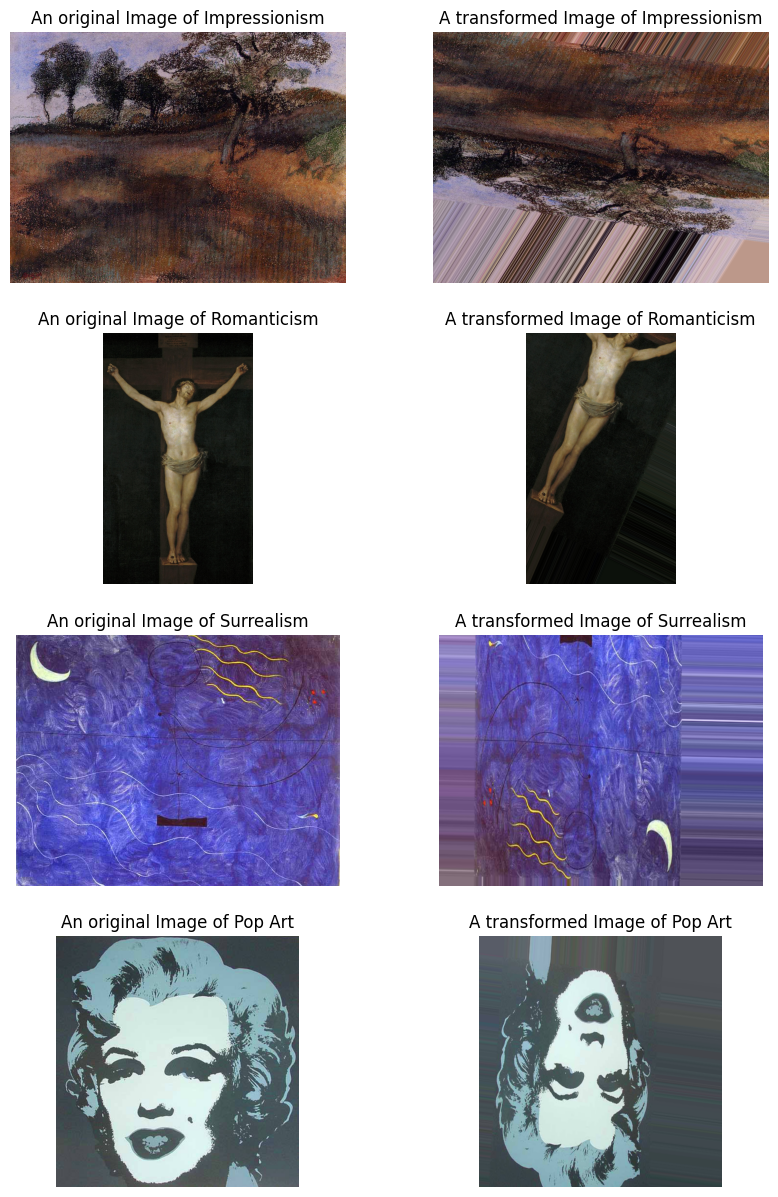

In [18]:
# Print a random paintings and it's random augmented version
col = 2
row = 4

fig, axes = plt.subplots(row, col, figsize=(10,15))


# Original image
for i in range(row):
    random_artist = random.choice(artists_genre)
    random_image = random.choice(os.listdir(os.path.join(images_dir, random_artist)))
    random_image_file = os.path.join(images_dir, random_artist, random_image)
    
    image = plt.imread(random_image_file)
    axes[i][0].imshow(image)
    axes[i][0].set_title("An original Image of " + random_artist.replace('_', ' '))
    axes[i][0].axis('off')

    # Transformed image
    aug_image = train_datagen.random_transform(image)
    axes[i][1].imshow(aug_image)
    axes[i][1].set_title("A transformed Image of " + random_artist.replace('_', ' '))
    axes[i][1].axis('off')

plt.show()

## RESNET


In [19]:
import tensorflow as tf
from tensorflow.keras import layers, models

def build_model():
    input_shape = (224, 224, 3)

    model = tf.keras.applications.vgg19.VGG19(
        include_top=False,
        weights=None,  # 미리 훈련된 가중치 사용 여부
        input_tensor=tf.keras.Input(shape=input_shape),
        classes= n_classes # 분류할 클래스 수
        
    )

    return model

# ResNet-50 모델 생성
base_model = build_model()

In [20]:
for layer in base_model.layers:
    layer.trainable = False

# Add layers at the end
X = base_model.output
X = Flatten()(X)

X = Dense(128, kernel_initializer='he_uniform')(X)
#X = Dropout(0.5)(X)
X = BatchNormalization()(X)
X = Activation('relu')(X)

X = Dense(16, kernel_initializer='he_uniform')(X)
#X = Dropout(0.5)(X)
X = BatchNormalization()(X)
X = Activation('relu')(X)

output = Dense(n_classes, activation='softmax')(X)

model = Model(inputs=base_model.input, outputs=output)
    
    
# 모델 요약 출력
model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 224, 224, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 224, 224, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 112, 112, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 112, 112, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 112, 112, 128)     147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 56, 56, 128)       0     

In [21]:
optimizer = AdamW(learning_rate=0.001)
model.compile(loss='categorical_crossentropy',
              optimizer=optimizer, 
              metrics=['accuracy'])

In [22]:
n_epoch = 20

early_stop = EarlyStopping(monitor='val_loss', patience=5, verbose=1, 
                           mode='auto', restore_best_weights=True)

reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.1, patience=2, 
                              verbose=1, mode='auto')

In [23]:
history1 = model.fit(train_generator, steps_per_epoch=STEP_SIZE_TRAIN,
                              validation_data=valid_generator, validation_steps=STEP_SIZE_VALID,
                              epochs=n_epoch,
                              shuffle=True,
                              verbose=1,
                               use_multiprocessing=True,
                              callbacks=[reduce_lr],
                              workers=16,
                            class_weight=class_weights
                             )

Epoch 1/20
295/295 [==============================] - 73s 212ms/step - loss: 2.4027 - accuracy: 0.1612 - val_loss: 2.3865 - val_accuracy: 0.1670 - lr: 0.0010
Epoch 2/20
295/295 [==============================] - 62s 203ms/step - loss: 2.2574 - accuracy: 0.2628 - val_loss: 2.3506 - val_accuracy: 0.1498 - lr: 0.0010
Epoch 3/20
295/295 [==============================] - 61s 201ms/step - loss: 2.1912 - accuracy: 0.2717 - val_loss: 3.1613 - val_accuracy: 0.0771 - lr: 0.0010
Epoch 4/20
295/295 [==============================] - ETA: 0s - loss: 2.1458 - accuracy: 0.2949
Epoch 4: ReduceLROnPlateau reducing learning rate to 0.00010000000474974513.
295/295 [==============================] - 60s 199ms/step - loss: 2.1458 - accuracy: 0.2949 - val_loss: 2.7866 - val_accuracy: 0.0813 - lr: 0.0010
Epoch 5/20
295/295 [==============================] - 58s 191ms/step - loss: 2.1044 - accuracy: 0.2959 - val_loss: 2.2140 - val_accuracy: 0.2140 - lr: 1.0000e-04
Epoch 6/20
295/295 [========================

## history

In [24]:
# Merge history1 and history2
history = {}
history['loss'] = history1.history['loss'] #+ history2.history['loss']
history['accuracy'] = history1.history['accuracy'] #+ history2.history['accuracy']
history['val_loss'] = history1.history['val_loss'] #+ history2.history['val_loss']
history['val_accuracy'] = history1.history['val_accuracy'] #+ history2.history['val_accuracy']
# history['learning_rate'] = history1.history['learning_rate'] + history2.history['learning_rate']

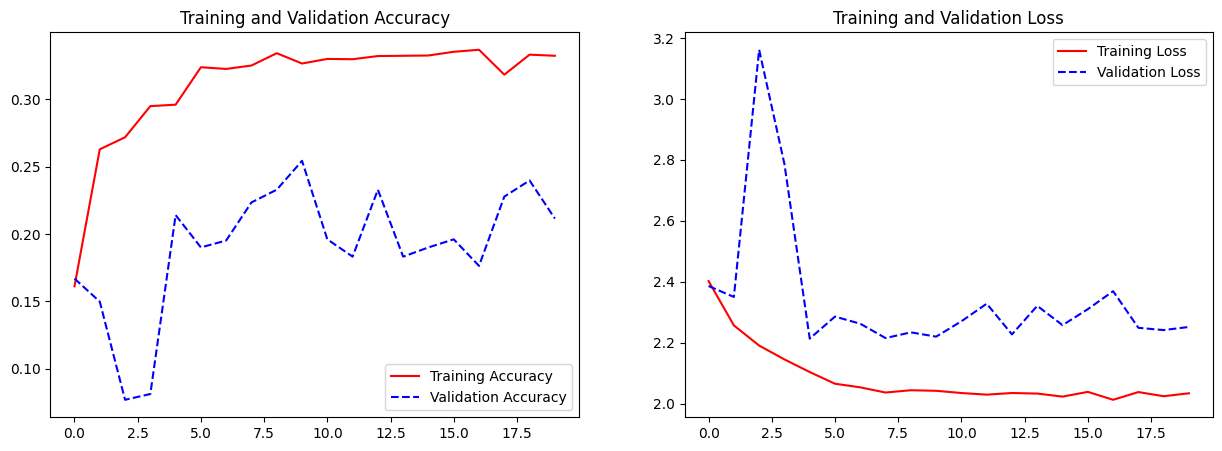

In [25]:

# Plot the training graph
def plot_training(history):
    acc = history['accuracy']
    val_acc = history['val_accuracy']
    loss = history['loss']
    val_loss = history['val_loss']
    epochs = range(len(loss))

    fig, axes = plt.subplots(1, 2, figsize=(15,5))
    
    axes[0].plot(epochs, acc, 'r-', label='Training Accuracy')
    axes[0].plot(epochs, val_acc, 'b--', label='Validation Accuracy')
    axes[0].set_title('Training and Validation Accuracy')
    axes[0].legend(loc='best')

    axes[1].plot(epochs, loss, 'r-', label='Training Loss')
    axes[1].plot(epochs, val_loss, 'b--', label='Validation Loss')
    axes[1].set_title('Training and Validation Loss')
    axes[1].legend(loc='best')
    
    plt.show()
    
plot_training(history)

## result

In [26]:
# Prediction accuracy on train data
score = model.evaluate_generator(train_generator, verbose=1)
print("Prediction accuracy on train data =%.3f"%score[1])

/tmp/ipykernel_42/3410001329.py:2: UserWarning: `Model.evaluate_generator` is deprecated and will be removed in a future version. Please use `Model.evaluate`, which supports generators.
  score = model.evaluate_generator(train_generator, verbose=1)


296/296 [==============================] - 80s 271ms/step - loss: 2.2295 - accuracy: 0.3510
Prediction accuracy on train data =0.351


In [27]:
# Prediction accuracy on CV data
score = model.evaluate_generator(valid_generator, verbose=1)
print("Prediction accuracy on CV data =%.3f"%score[1])

/tmp/ipykernel_42/3290181623.py:2: UserWarning: `Model.evaluate_generator` is deprecated and will be removed in a future version. Please use `Model.evaluate`, which supports generators.
  score = model.evaluate_generator(valid_generator, verbose=1)


74/74 [==============================] - 21s 281ms/step - loss: 3.7376 - accuracy: 0.2107
Prediction accuracy on CV data =0.211


1/1 [==============================] - 0s 24ms/step


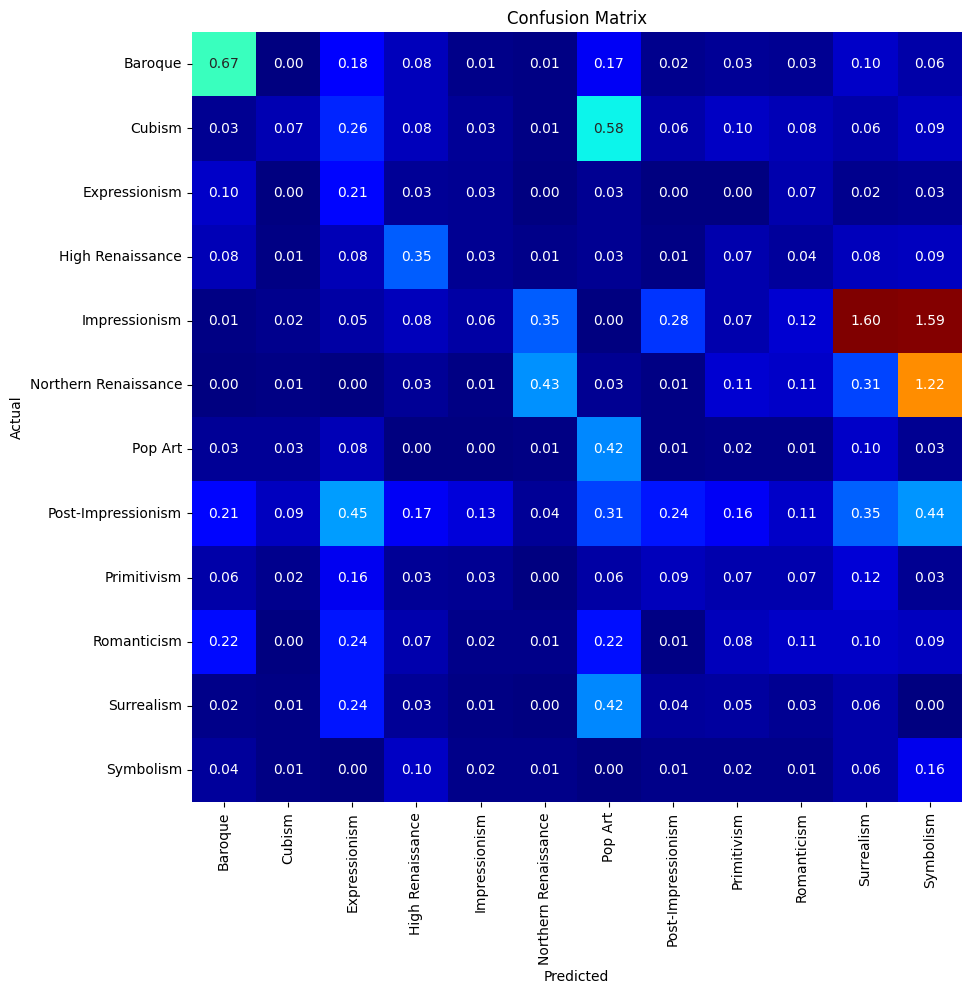

Classification Report:
                      precision    recall  f1-score   support

             Baroque       0.46      0.67      0.55       116
              Cubism       0.24      0.07      0.11        86
       Expressionism       0.11      0.21      0.14        38
    High Renaissance       0.33      0.35      0.34        60
       Impressionism       0.15      0.06      0.08       272
Northern Renaissance       0.49      0.43      0.46       135
             Pop Art       0.19      0.42      0.26        36
  Post-Impressionism       0.30      0.24      0.26       208
         Primitivism       0.09      0.07      0.07        61
         Romanticism       0.14      0.11      0.12        76
          Surrealism       0.02      0.06      0.03        48
           Symbolism       0.04      0.16      0.06        32

            accuracy                           0.23      1168
           macro avg       0.21      0.24      0.21      1168
        weighted avg       0.25      0.23    

In [28]:
# Classification report and confusion matrix
from sklearn.metrics import *
import seaborn as sns

tick_labels = artists_genre

def showClassficationReport_Generator(model, valid_generator, STEP_SIZE_VALID):
    # Loop on each generator batch and predict
    y_pred, y_true = [], []
    for i in range(STEP_SIZE_VALID):
        (X,y) = next(valid_generator)
        y_pred.append(model.predict(X))
        y_true.append(y)
    
    # Create a flat list for y_true and y_pred
    y_pred = [subresult for result in y_pred for subresult in result]
    y_true = [subresult for result in y_true for subresult in result]
    
    # Update Truth vector based on argmax
    y_true = np.argmax(y_true, axis=1)
    y_true = np.asarray(y_true).ravel()
    
    # Update Prediction vector based on argmax
    y_pred = np.argmax(y_pred, axis=1)
    y_pred = np.asarray(y_pred).ravel()
    
    # Confusion Matrix
    fig, ax = plt.subplots(figsize=(10,10))
    conf_matrix = confusion_matrix(y_true, y_pred, labels=np.arange(n_classes))
    conf_matrix = conf_matrix/np.sum(conf_matrix, axis=1)
    sns.heatmap(conf_matrix, annot=True, fmt=".2f", square=True, cbar=False, 
                cmap=plt.cm.jet, xticklabels=tick_labels, yticklabels=tick_labels,
                ax=ax)
    ax.set_ylabel('Actual')
    ax.set_xlabel('Predicted')
    ax.set_title('Confusion Matrix')
    plt.show()
    
    print('Classification Report:')
    print(classification_report(y_true, y_pred, labels=np.arange(n_classes), target_names=artists_genre))

showClassficationReport_Generator(model, valid_generator, STEP_SIZE_VALID)